In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tree-species-dataset/Tree_Species_Dataset/vad/images (4).jpeg
/kaggle/input/tree-species-dataset/Tree_Species_Dataset/vad/download (3).jpeg
/kaggle/input/tree-species-dataset/Tree_Species_Dataset/vad/download (4).jpeg
/kaggle/input/tree-species-dataset/Tree_Species_Dataset/vad/images (27).jpeg
/kaggle/input/tree-species-dataset/Tree_Species_Dataset/vad/images.jpeg
/kaggle/input/tree-species-dataset/Tree_Species_Dataset/vad/images (23).jpeg
/kaggle/input/tree-species-dataset/Tree_Species_Dataset/vad/download (9).jpeg
/kaggle/input/tree-species-dataset/Tree_Species_Dataset/vad/download (7).jpeg
/kaggle/input/tree-species-dataset/Tree_Species_Dataset/vad/images (9).jpeg
/kaggle/input/tree-species-dataset/Tree_Species_Dataset/vad/images (7).jpeg
/kaggle/input/tree-species-dataset/Tree_Species_Dataset/vad/images (19).jpeg
/kaggle/input/tree-species-dataset/Tree_Species_Dataset/vad/images (33).jpeg
/kaggle/input/tree-species-dataset/Tree_Species_Dataset/vad/images (16).jpeg
/ka

In [2]:
import os
len(os.listdir("/kaggle/input/tree-species-dataset/Tree_Species_Dataset"))

31

In [3]:
import os
import glob

repo_path = "/kaggle/input/tree-species-dataset/Tree_Species_Dataset"

image_paths = []
labels = []

for class_name in os.listdir(repo_path):
    class_folder = os.path.join(repo_path, class_name)
    if os.path.isdir(class_folder):
        for img_file in os.listdir(class_folder):
            image_paths.append(os.path.join(class_folder, img_file))
            labels.append(class_name)

print(f"Total images: {len(image_paths)}")

Total images: 1605


In [4]:
import pandas as pd

repo_path = "/kaggle/input/tree-species-dataset/Tree_Species_Dataset"
class_dirs = os.listdir(repo_path)

class_counts = {cls: len(os.listdir(os.path.join(repo_path, cls))) for cls in class_dirs}
class_counts_df = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Image Count'])

print(class_counts_df.sort_values('Image Count', ascending=False).head())
print("shape: ", class_counts_df.shape)

            Image Count
other               150
saptaparni           50
vad                  50
kanchan              50
champa               50
shape:  (31, 1)


In [5]:
from PIL import Image
import os
import pandas as pd

image_shapes = []

for class_dir in class_dirs:
    class_path = os.path.join(repo_path, class_dir)
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)

        try:
            img = Image.open(img_path)
            image_shapes.append(img.size)
        except:
            pass  # silently skip unreadable/corrupt images

shapes_df = pd.DataFrame(image_shapes, columns=["Width", "Height"])
shapes_df.head()

,Width,Height
0,194,259
1,251,201
2,225,225
3,259,194
4,225,225


In [6]:
print(shapes_df.describe())

             Width       Height
count  1600.000000  1600.000000
mean    312.623125   269.821875
std     296.220501   278.014229
min     141.000000   128.000000
25%     225.000000   183.000000
50%     259.000000   200.000000
75%     275.000000   259.000000
max    4000.000000  4032.000000


In [7]:
image_info = []

for class_dir in class_dirs:
    class_path = os.path.join(repo_path, class_dir)
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        try:
            with Image.open(img_path) as img:
                width, height = img.size
                image_info.append({
                    'path': img_path,
                    'width': width,
                    'height': height,
                    'class': class_dir
                })
        except:
            continue

df_sizes = pd.DataFrame(image_info)
print(df_sizes[['width', 'height']].describe())
# torture the data until it reveals everything

             width       height
count  1600.000000  1600.000000
mean    312.623125   269.821875
std     296.220501   278.014229
min     141.000000   128.000000
25%     225.000000   183.000000
50%     259.000000   200.000000
75%     275.000000   259.000000
max    4000.000000  4032.000000


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Define parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Augmentation and rescaling
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(
    repo_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    repo_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

2025-08-02 17:42:35.997881: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754156556.370414      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754156556.469483      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 1280 images belonging to 31 classes.
Found 320 images belonging to 31 classes.


In [9]:
import tensorflow as tf
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S, preprocess_input

folder_path='/kaggle/input/tree-species-dataset/Tree_Species_Dataset'

train_ds=tf.keras.preprocessing.image_dataset_from_directory(
    folder_path,
    validation_split=0.2,
    shuffle=True,
    label_mode='int',
    seed=42,
    batch_size=32,
    subset='training',
    image_size=(384, 384)
)

test_ds=tf.keras.preprocessing.image_dataset_from_directory(
    folder_path,
    validation_split=0.2,
    label_mode='int',
    subset='validation',
    seed=42,
    batch_size=32,
    image_size=(384, 384)
)

AUTOTUNE=tf.data.AUTOTUNE
train_ds=train_ds.map(lambda x,y:(preprocess_input(x),y),num_parallel_calls=AUTOTUNE)
test_ds=test_ds.map(lambda x,y:(preprocess_input(x),y),num_parallel_calls=AUTOTUNE)

train_ds=train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds=test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1600 files belonging to 30 classes.
Using 1280 files for training.


I0000 00:00:1754156575.038496      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754156575.039264      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 1600 files belonging to 30 classes.
Using 320 files for validation.


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

base_model = EfficientNetV2S(
    include_top=False,
   weights='/kaggle/input/eeeeee/efficientnetv2-s_notop.h5', 
   # weights='imagenet',
    input_shape=(384, 384, 3),
    pooling='avg'
)

model=Sequential()
model.add(base_model)
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu',kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(30,activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0009),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-s (Functional)   │ (None, 1280)           │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 30)             │         1,950 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,506,302 (78.23 MB)

 Trainable params: 20,352,046 (77.64 MB)

 Non-trainable params: 154,256 (602.56 KB)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=28,
    callbacks=[early_stop])

Epoch 1/28


I0000 00:00:1754156695.838710      83 service.cc:148] XLA service 0x7f6e344550c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754156695.841441      83 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1754156695.841467      83 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1754156706.776273      83 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1754156732.304528      83 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1754156732.474918      83 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1754156733.297183      83 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. Th

40/40 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.1221 - loss: 3.5767 - val_accuracy: 0.4594 - val_loss: 2.5378
Epoch 2/28
40/40 ━━━━━━━━━━━━━━━━━━━━ 38s 951ms/step - accuracy: 0.3702 - loss: 2.3114 - val_accuracy: 0.6187 - val_loss: 1.7454
Epoch 3/28
40/40 ━━━━━━━━━━━━━━━━━━━━ 38s 960ms/step - accuracy: 0.5505 - loss: 1.7519 - val_accuracy: 0.7125 - val_loss: 1.3068
Epoch 4/28
40/40 ━━━━━━━━━━━━━━━━━━━━ 38s 943ms/step - accuracy: 0.7457 - loss: 1.1912 - val_accuracy: 0.7281 - val_loss: 1.1440
Epoch 5/28
40/40 ━━━━━━━━━━━━━━━━━━━━ 38s 961ms/step - accuracy: 0.8416 - loss: 0.8868 - val_accuracy: 0.7781 - val_loss: 0.9394
Epoch 6/28
40/40 ━━━━━━━━━━━━━━━━━━━━ 38s 942ms/step - accuracy: 0.8677 - loss: 0.7141 - val_accuracy: 0.7531 - val_loss: 1.1509
Epoch 7/28
40/40 ━━━━━━━━━━━━━━━━━━━━ 38s 958ms/step - accuracy: 0.8891 - loss: 0.6021 - val_accuracy: 0.8062 - val_loss: 0.8520
Epoch 8/28
40/40 ━━━━━━━━━━━━━━━━━━━━ 38s 952ms/step - accuracy: 0.9244 - loss: 0.4898 - val_accuracy: 0.8062 

In [12]:
for layer in base_model.layers[-150:]:
    layer.trainable=True

for layer in base_model.layers[:-150]:
    layer.trainable=False

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


early_stop1 = EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

history_finetune = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=30,
    callbacks=[early_stop1]
)

Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 115s 705ms/step - accuracy: 0.9400 - loss: 0.4752 - val_accuracy: 0.8125 - val_loss: 0.8291
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 426ms/step - accuracy: 0.9563 - loss: 0.4174 - val_accuracy: 0.8125 - val_loss: 0.8239
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 438ms/step - accuracy: 0.9405 - loss: 0.4807 - val_accuracy: 0.8156 - val_loss: 0.8149
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 407ms/step - accuracy: 0.9478 - loss: 0.4496 - val_accuracy: 0.8156 - val_loss: 0.8107
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 397ms/step - accuracy: 0.9655 - loss: 0.4045 - val_accuracy: 0.8125 - val_loss: 0.8071
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 409ms/step - accuracy: 0.9550 - loss: 0.3908 - val_accuracy: 0.8219 - val_loss: 0.8044
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 412ms/step - accuracy: 0.9439 - loss: 0.4228 - val_accuracy: 0.8219 - val_loss: 0.8006
Epoch 8/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 420ms/step - accuracy: 0.9617 - loss: 0.3799 - val_acc

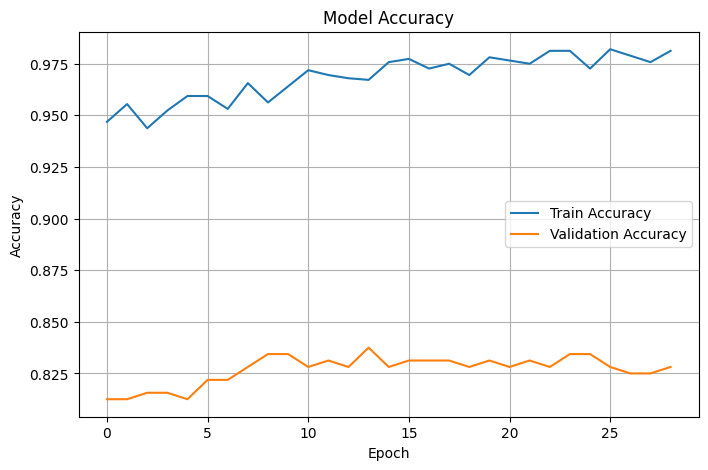

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history_finetune.history['accuracy'], label='Train Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


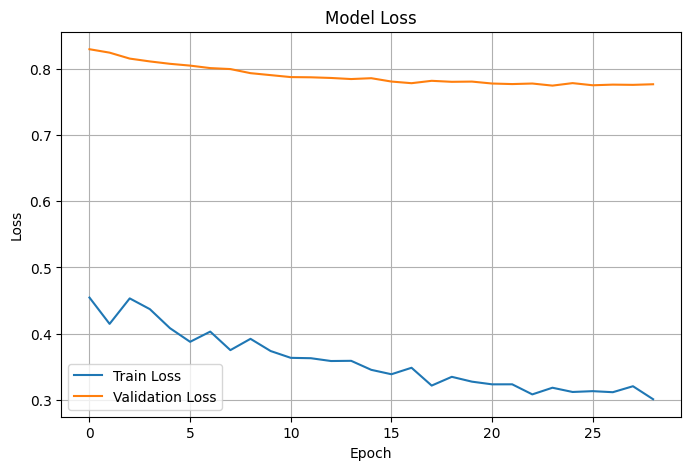

In [14]:
plt.figure(figsize=(8, 5))
plt.plot(history_finetune.history['loss'], label='Train Loss')
plt.plot(history_finetune.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
